# MNIST in Caffe


In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt

# display plots in this notebook
%matplotlib inline

from pylab import *
import sys
import os

# set display defaults
plt.rcParams['figure.figsize'] = (5, 5)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.

caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')
import caffe

In [3]:
os.chdir(caffe_root)
# Download data
!data/mnist/get_mnist.sh
# Prepare data
!examples/mnist/create_mnist.sh
# back to examples
os.chdir('examples')
caffe.set_mode_gpu()

Downloading...
Creating lmdb...
I0703 10:10:01.815647  6270 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_train_lmdb
I0703 10:10:01.816277  6270 convert_mnist_data.cpp:88] A total of 60000 items.
I0703 10:10:01.816316  6270 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0703 10:10:04.455206  6270 convert_mnist_data.cpp:108] Processed 60000 files.
I0703 10:10:05.268309  6272 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_test_lmdb
I0703 10:10:05.268965  6272 convert_mnist_data.cpp:88] A total of 10000 items.
I0703 10:10:05.269002  6272 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0703 10:10:05.693559  6272 convert_mnist_data.cpp:108] Processed 10000 files.
Done.


In [4]:
! pwd

/home/nvidia/caffe/examples


In [27]:
def plot_loss_accuracy(train_loss, test_loss, train_acc, test_acc, train_pars) :
    niter = train_pars['niter']
    test_interval = train_pars['test_interval']
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    ax1.plot(arange(niter), train_loss, 'r-',label= "loss_train",alpha=0.3)
    ax1.plot(test_interval * arange(len(test_acc+1)), test_loss, 'r.-',label= "loss_test")
    ax2.plot(arange(niter), train_acc, 'b-',label= "acc_train",alpha=0.7)
    ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'b.-',label= "acc_test")
    ax1.set_ylim([0,2.5])
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('train loss')
    ax2.set_ylabel('test accuracy')

    ax2.set_ylim([0,1])
    ax1.legend(loc='center right')
    ax2.legend(loc='best')
    ax1.minorticks_on()
    ax1.grid(which="both")
     

In [7]:
def runLearning_bulky(solver):
    #%%time
    niter = 9370 # 64 samples in 1 batch * 9370 samples = 599680 samples (approx. 10 epochs x 60000 samples)
    test_interval = 937  # Run validation after each epoch
    test_iter = 100  # batch size for test = 100, * 100 batches = 10000
    # losses will also be stored in the log
    train_loss = zeros(niter)
    train_acc = zeros(niter)
    test_loss = zeros(niter // test_interval+1)
    test_acc = zeros(niter // test_interval+1)
    output = zeros((niter, 8, 10))

    # the main solver loop
    for it in range(niter):
        solver.step(1)  

        # store the train loss
        train_loss[it] = solver.net.blobs['loss'].data
        train_acc[it] = solver.net.blobs['accuracy'].data
        # store the output on the first test batch
        # (start the forward pass at conv1 to avoid loading new data)
        solver.test_nets[0].forward(start='conv1')
        output[it] = solver.test_nets[0].blobs['dense_1'].data[:8]

        # run a full test every so often
        # (Caffe can also do this for us and write to a log, but we show here
        #  how to do it directly in Python, where more complicated things are easier.)
        if it % test_interval == 0:
            #print 'Iteration', it, 'testing...'
            acc_ = 0
            loss_ = 0
            for test_it in range(test_iter):
                solver.test_nets[0].forward()
                acc_ += solver.test_nets[0].blobs['accuracy'].data
                loss_ += solver.test_nets[0].blobs['loss'].data
            test_acc[it // test_interval] = acc_ / test_iter
            test_loss[it // test_interval] = loss_ / test_iter
            #print "Round ", it, test_interval, it // test_interval
            print "Test acc:", test_acc[it // test_interval],"Loss:", test_loss[it // test_interval]
        
    train_pars={'niter':niter, 'test_interval': test_interval}
    plot_loss_accuracy(train_loss, test_loss, train_acc, test_acc, train_pars)   
      

# Load model and start learning

In [8]:
from caffe import layers as L, params as P

In [24]:
from __future__ import division

## Change model to match that in Keras

60001 iteration
Iteration 0 testing...
Iteration 6000 testing...
Iteration 12000 testing...
Iteration 18000 testing...
Iteration 24000 testing...
Iteration 30000 testing...
Iteration 36000 testing...
Iteration 42000 testing...
Iteration 48000 testing...
Iteration 54000 testing...
Iteration 60000 testing...


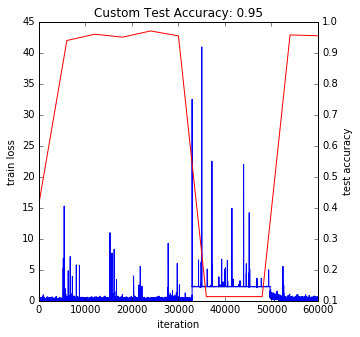

In [31]:
train_net_path = 'mnist/custom_auto_train.prototxt'
test_net_path = 'mnist/custom_auto_test.prototxt'
solver_config_path = 'mnist/custom_auto_solver.prototxt'

### define net
def custom_net(lmdb, batch_size):
    # define your own net!
    n = caffe.NetSpec()
    
    # keep this data layer for all networks
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    # MODEL
    n.conv1 = L.Convolution(n.data, kernel_size=3, num_output=32, weight_filler=dict(type='xavier'))
    n.act1 = L.TanH(n.conv1)
    n.conv2 = L.Convolution(n.act1, kernel_size=3, num_output=32, weight_filler=dict(type='xavier'))
    n.act2 = L.ReLU(n.conv2)
    n.pool1 = L.Pooling(n.act2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.flat1 = L.Flatten(n.pool1)
    n.drop1 = L.Dropout(n.flat1,  dropout_ratio=0.25)
    n.score = L.InnerProduct(n.drop1, num_output=10, weight_filler=dict(type='xavier'))
    
    # keep this loss layer for all networks
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    n.accuracy  =  L.Accuracy(n.score, n.label)
    return n.to_proto()

with open(train_net_path, 'w') as f:
    f.write(str(custom_net('mnist/mnist_train_lmdb', 64)))    
with open(test_net_path, 'w') as f:
    f.write(str(custom_net('mnist/mnist_test_lmdb', 100)))

### define solver
from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

# Set a seed for reproducible experiments:
# this controls for randomization in training.
s.random_seed = 0xCAFFE

# Specify locations of the train and (maybe) test networks.
s.train_net = train_net_path
s.test_net.append(test_net_path)
s.test_interval = 6000  # Test after every N training iterations.
s.test_iter.append(100) # Test on 100 batches each time we test.

s.max_iter = 60000     # no. of times to update the net (training iterations)
 
# EDIT HERE to try different solvers
# solver types include "SGD", "Adam", and "Nesterov" among others.
s.type = "Adam"

# Set the initial learning rate for SGD.
s.base_lr = 0.01  # EDIT HERE to try different learning rates
# Set momentum to accelerate learning by
# taking weighted average of current and previous updates.
s.momentum = 0.9
# Set weight decay to regularize and prevent overfitting
s.weight_decay = 0.0005

# Set `lr_policy` to define how the learning rate changes during training.
s.lr_policy = 'fixed'
#s.gamma = 0.0001
#s.power = 0.75

# Display the current training loss and accuracy every 1000 iterations.
s.display = 1000

# Snapshots are files used to store networks we've trained.
# We'll snapshot every 5K iterations -- twice during training.
s.snapshot = 60000
s.snapshot_prefix = 'mnist/custom_net'

# Train on the GPU
s.solver_mode = caffe_pb2.SolverParameter.GPU

# Write the solver to a temporary file and return its filename.
with open(solver_config_path, 'w') as f:
    f.write(str(s))

### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.get_solver(solver_config_path)

### solve
niter = s.max_iter+1  # +1 to run evaluation at the end of training (last iteration num. will be max_iter)
test_interval = niter // 10
test_iter = 100
print niter, "iteration"
# losses will also be stored in the log
train_loss = zeros(niter)
train_acc  = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
test_loss= zeros(int(np.ceil(niter / test_interval)))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    train_acc[it] = solver.net.blobs['accuracy'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        acc_ = 0
        loss_ = 0
        for test_it in range(test_iter):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
            acc_ += solver.test_nets[0].blobs['accuracy'].data
            loss_ += solver.test_nets[0].blobs['loss'].data

        test_acc[it // test_interval] = correct / 1e4
        test_loss[it // test_interval] = loss_ / test_iter

_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Custom Test Accuracy: {:.2f}'.format(test_acc[-1]))


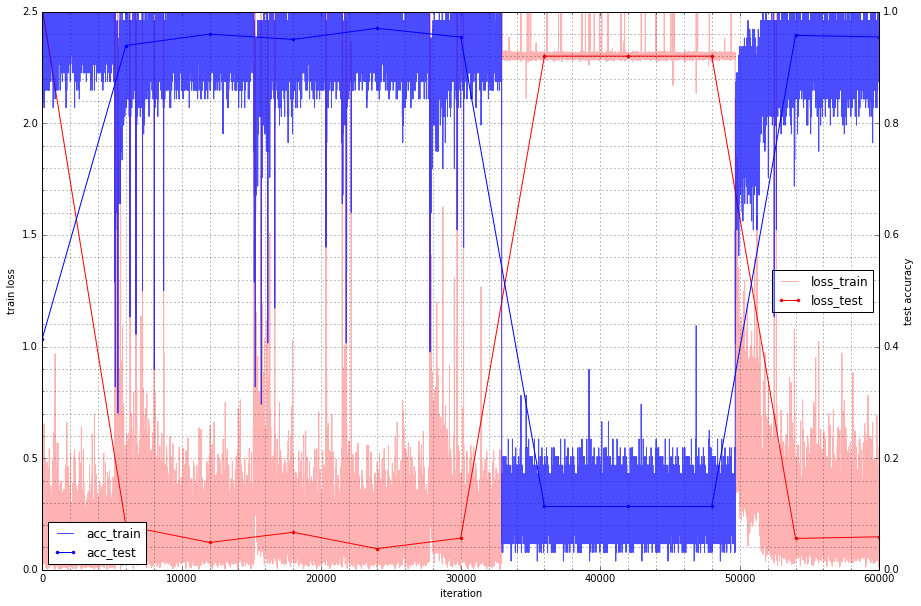

In [32]:
train_pars={'niter':niter, 'test_interval': test_interval}
plot_loss_accuracy(train_loss, test_loss, train_acc, test_acc, train_pars)

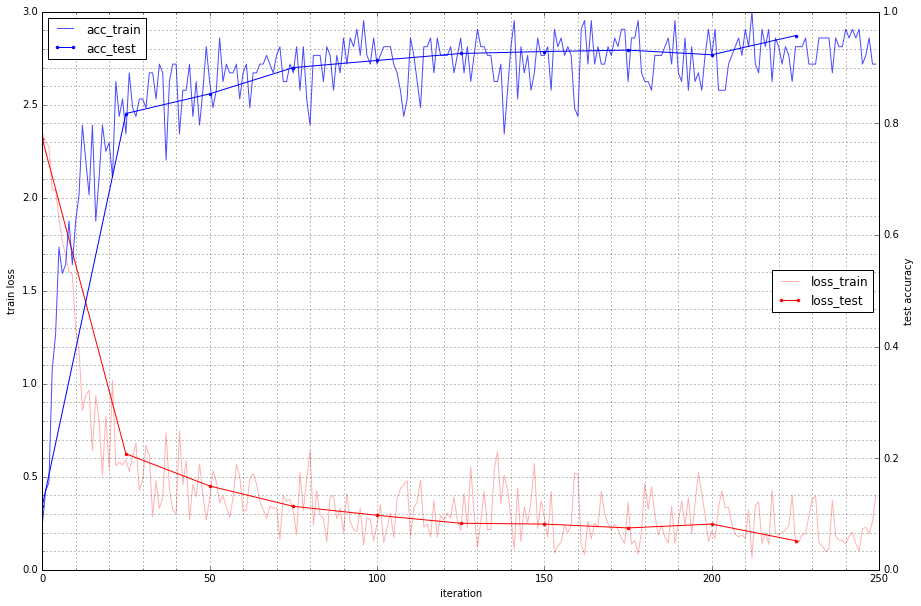

In [10]:
train_pars={'niter':niter, 'test_interval': test_interval}
plot_loss_accuracy(train_loss, test_loss, train_acc, test_acc, train_pars)

In [ ]:
plot_loss_accuracy(train_loss, test_loss, train_acc, test_acc, train_pars)

In [ ]:
runLearning(caffe.SGDSolver('mnist/transfer_cnn_mnist_solver.prototxt'))

In [ ]:
runLearning(caffe.SGDSolver('mnist/transfer_cnn_mnist_solver.prototxt'))

In [ ]:
# Batch size 32
# test_iter: 100
runLearning(caffe.SGDSolver('mnist/transfer_cnn_mnist_solver.prototxt'))

### Plotting functions (corssentropy etc.)

In [ ]:
a = np.arange(0.01,2,0.02)
y1 = -np.log(a)
y2 = -np.log(1-a)
k = 0.4
y3 = -k*np.log(a) - (1 - k)*np.log(1-a)
plt.plot(a,y1,label="-ln(a), y=1")
plt.plot(a,y2,label="-ln(1-a),y=0")
plt.plot(a,y3,label="-"+str(k)+"*ln(a) - (1-"+str(k)+")*ln(1-a))")
plt.legend(loc="upper left")
plt.grid(True)

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
x = np.arange(-10,10,0.1)
y = sigmoid(x)
dy = (1 - sigmoid(x))*sigmoid(x)
plt.plot(x,y,label="sigmoid")
plt.plot(x,dy,label="$ \sigma' $")
plt.legend(loc="upper left")
plt.grid(True)

In [ ]:
def quadratic(a,y):
    return np.power(y - a,2)/2

x_ = np.arange(0,1,0.2)
w = np.arange(-50,51.1,1)
y1 = 1
y0 = 0
for x in x_: 
    a = sigmoid(x*w)
    #plt.plot(w,a,label="a,x="+str(x))
    #C1 = quadratic(a,y1)
    C0 = quadratic(a,y0)
    #plt.plot(w,C1,label="C1,x="+str(x))
    plt.plot(w,C0,label="C0,x="+str(x))

plt.legend(loc="upper left")
plt.title("Quadratic cost function C(x)")
plt.grid(True)

In [ ]:
def crossentropy(a,y):
    return -y*np.log(a) - (1-y)*np.log(1-a)

x_ = np.arange(0,1,0.2)
w = np.arange(-50,51,1)
y1 = 1
y0 = 0
for x in x_: 
    a = sigmoid(x*w)
    #plt.plot(w,a,label="a,x="+str(x))
    #C1 = quadratic(a,y1)
    C0 = crossentropy(a,y0)
    #plt.plot(w,C1,label="C1,x="+str(x))
    plt.plot(w,C0,label="C0,x="+str(x))

plt.legend(loc="upper left")
plt.title("Cross-entropy cost function")
plt.grid(True)